In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pickle
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
from itertools import cycle
from DifferentiableHOS.ks_tf import ks93_tf, ks93inv_tf
from DifferentiableHOS.NLA_IA import  Epsilon2,Epsilon1,tidal_field,interpolation
from DifferentiableHOS.fourier_smoothing import fourier_smoothing
from flowpm.tfbackground import rad_comoving_distance

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.cosmology import Planck15
import astropy.units as u
from flowpm import tfpm
from flowpm.utils import cic_paint, compensate_cic
from flowpm.tfpower import linear_matter_power
from functools import partial
from flowpm.tfbackground import Omega_m_a, D1
import flowpm.constants as constants

In [3]:
# Loads PGD parameters
with open('/global/u1/d/dlan/DifferentiableHOS/notebooks/results_fit_PGD_205_128.pkl', "rb") as f:
    pgd_data = pickle.load(f)
    pgdparams = pgd_data['params']

In [4]:
# Below are a few parameters
n_lens = 11       # Number of lensplanes in the lightcone
box_size = 205.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field 
batch_size = 1    # Number of simulations to run in parallel

In [5]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [6]:

#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [7]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True,
                      pgdparams=None) 

In [8]:
lens_source=states[::-1][11][1]
lens_source_a=states[::-1][11][0]  
z_source=1/lens_source_a-1
r_source=rad_comoving_distance(cosmology,lens_source_a)


In [9]:
z_source

<tf.Tensor: shape=(), dtype=float32, numpy=0.9720714>

In [10]:
%%time
# Extract the lensplanes
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=2048,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift())
    plane = fourier_smoothing(plane,sigma=1.024,resolution=2048)
    lensplanes.append((r_center[i], states[::-1][i][0], plane))

CPU times: user 48 s, sys: 31.4 s, total: 1min 19s
Wall time: 32.2 s


In [11]:
%%time
# Get convergence map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/2048, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)
m= tf.reshape(m, [batch_size, field_npix,field_npix])

CPU times: user 6.26 s, sys: 1.61 s, total: 7.88 s
Wall time: 1.97 s


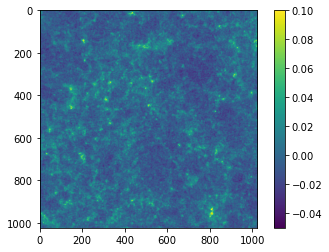

In [12]:
imshow(m[0],vmax=0.1, vmin=-0.05)
colorbar()

In [13]:
# pix_scale = field_size/field_npix*60              # arcmin
# sigma_pix=1/pix_scale
# def desc_y1_analysis(kmap):
#     """
#   Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
#   """
#     ngal = 10  # gal/arcmin **2
#     pix_scale = field_size / field_npix * 60  # arcmin
#     ngal_per_pix = ngal * pix_scale**2  # galaxies per pixels
#     sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)  # Rescaled noise sigma
#     sigma_pix = 1. / pix_scale  # Smooth at 1 arcmin
#     # Add noise
#     kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
#     # Add smoothing
#     kmap = fourier_smoothing(kmap,
#                              sigma=sigma_pix,
#                              resolution=field_npix)
#     return kmap


In [14]:
tidial_plane_resolution=2048
tidial_field_npix=1024 #we need the same resolution of the convergence map

In [15]:
plane_source = flowpm.raytracing.density_plane(lens_source,
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=tidial_plane_resolution,
                                            )
plane_source = fourier_smoothing(plane_source,sigma=1.024,resolution=tidial_plane_resolution)

We are using a two-dimensional Gaussian filter with σG = 0.1Mpc/h according to https://arxiv.org/pdf/2107.08041.pdf

In [16]:
sigma_source=0.1 #Mpc/h
pix_scale_source = box_size/tidial_plane_resolution     #Mpc       
sigma_pix_source=sigma_source/pix_scale_source

In [17]:
sigma_pix_source

0.9990243902439025

In [18]:
A1=1 #1.5,2

In [19]:
tidal_planes=tidal_field(plane_source,tidial_plane_resolution,sigma_pix_source)

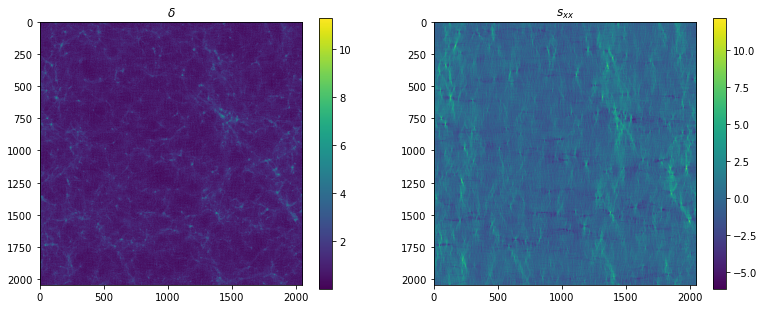

In [20]:
figure(figsize=[20,10])
subplot(131)
imshow(plane_source[0])
title('$\delta$')
colorbar(shrink=0.5)
subplot(132)
imshow(tidal_planes[0])
title('$s_{xx}$')
colorbar(shrink=0.5)
#savefig("tid1.png",dpi=150)


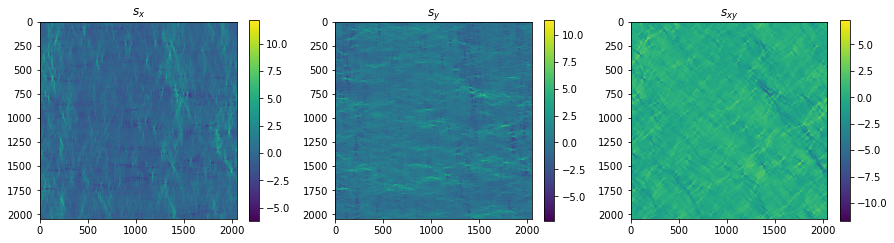

In [21]:
figure(figsize=[15,5])
subplot(131)
imshow(tidal_planes[0])
title('$s_x$')
colorbar(shrink=0.74)
subplot(132)
imshow(tidal_planes[1])
title('$s_y$')
colorbar(shrink=0.74)
subplot(133)
imshow(tidal_planes[2])
title('$s_{xy}$');
colorbar(shrink=0.74)

In [22]:
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size,tidial_field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size,tidial_field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [23]:
im=interpolation(tidal_planes,dx=box_size/tidial_plane_resolution,r_source=r_source,tidial_field_npix=tidial_field_npix,coords=c)

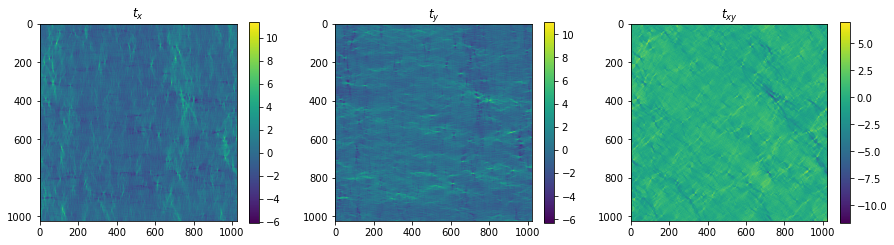

In [24]:
figure(figsize=[15,5])
subplot(131)
imshow(im[0])
title('$t_x$')
colorbar(shrink=0.74)
subplot(132)
imshow(im[1])
title('$t_y$')
colorbar(shrink=0.74)
subplot(133)
imshow(im[2])
title('$t_{xy}$');
colorbar(shrink=0.74)

In [25]:
e1=Epsilon1(cosmology, lens_source_a, im, A1)
e2=Epsilon2(cosmology, lens_source_a, im, A1)

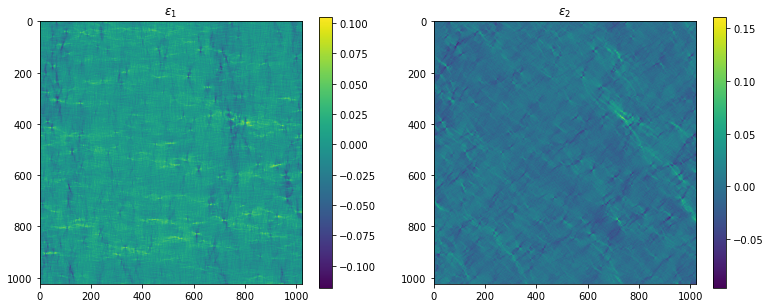

In [26]:
figure(figsize=[20,10])
subplot(131)
imshow(e1)
title('$\epsilon_1$')
colorbar(shrink=0.50)
subplot(132)
imshow(e2)
title('$\epsilon_2$')
colorbar(shrink=0.50)
#savefig("tid2.png",dpi=150)

In [27]:
ke_tf,kb_tf=ks93_tf(e1, e2)

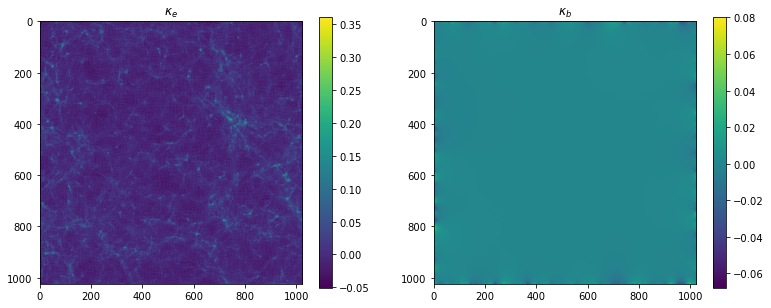

In [28]:
figure(figsize=[20,10])
subplot(131)
imshow(-ke_tf)
title('$\kappa_e$')
colorbar(shrink=0.5)
subplot(132)
imshow(kb_tf)
title('$\kappa_b$')
colorbar(shrink=0.5)
#plt.savefig("k_mod.png",dpi=250)

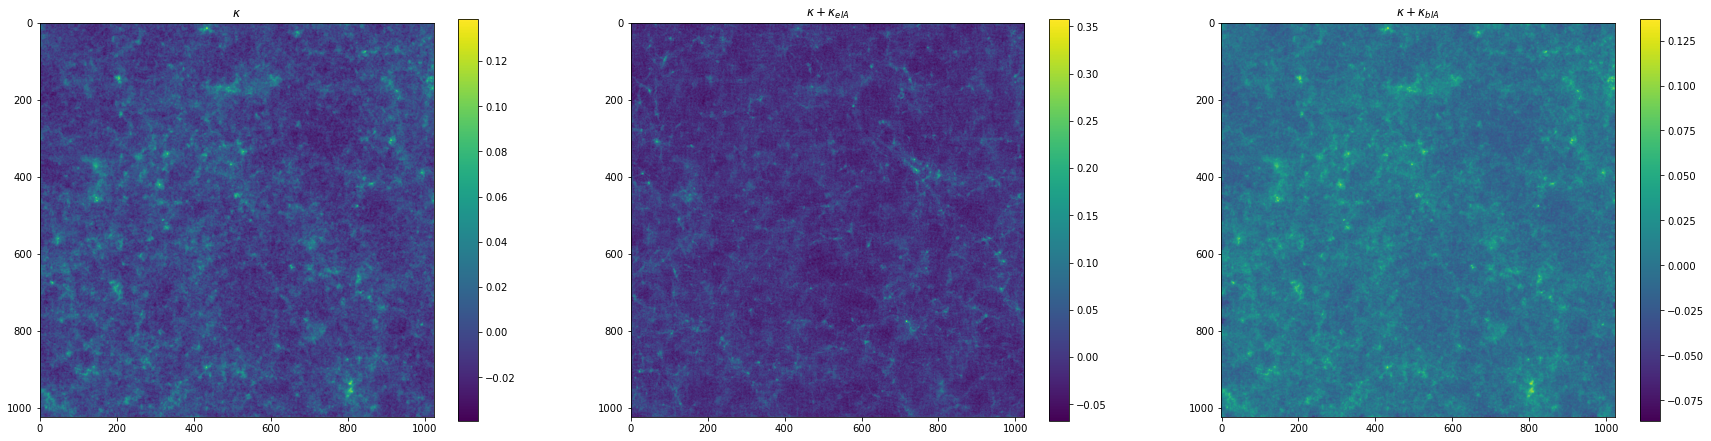

In [29]:
figure(figsize=[30,10])
subplot(131)
imshow(m[0])
title('$\kappa$')
colorbar(shrink=0.74)
subplot(132)
imshow(m[0]-ke_tf,)
title('$\kappa+\kappa_{eIA}$')
colorbar(shrink=0.74)
subplot(133)
imshow(m[0]+kb_tf)
title('$\kappa+\kappa_{bIA}$')
colorbar(shrink=0.74)
#plt.savefig("k_mod.png",dpi=250)

In [30]:
np.save("e.npy",np.stack([e1,e2]))

### Infusion in the more generic case

In [31]:
sigma_e = 0.26

In [32]:
random1=np.random.normal(0, sigma_e, e1.shape)
random2=np.random.normal(0, sigma_e, e2.shape)

In [33]:
g1,g2=ks93inv_tf(m[0], np.zeros(m[0].shape))

In [34]:
g=tf.cast(tf.complex(g1,g2),dtype=tf.complex64)
epsilon=tf.cast(tf.complex(e1,e2),dtype=tf.complex64)
epsilon_random=tf.cast(tf.complex(random1,random2),dtype=tf.complex64)

In [35]:
#epsilon_IA_TATT = epsilon_NLA * (1 + b_TA * delta) + epsilon_TT
epsilon_int = (epsilon + epsilon_random)/(1 + np.conjugate(epsilon) * epsilon_random)
epsilon_obs = (epsilon_int + g)/(1 + tf.math.conj(epsilon_int) * g)
epsilon_obs_no_noise = (epsilon+ g)/(1 + epsilon * tf.math.conj(g))

In [36]:
ke_tf,kb_tf=ks93_tf(tf.math.real(epsilon_obs_no_noise), tf.math.imag(epsilon_obs_no_noise))
#ke_tf,kb_tf=ks93_tf(epsilon_obs_no_noise, epsilon_obs_no_noise)

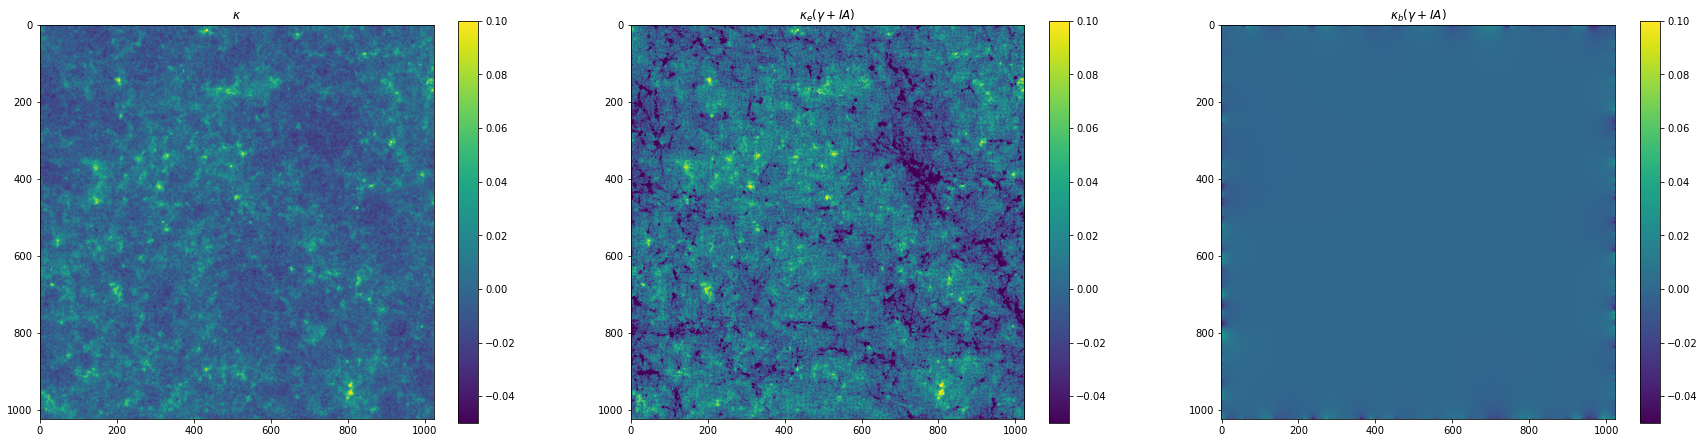

In [37]:
figure(figsize=[30,10])
subplot(131)
imshow(m[0],vmax=0.1, vmin=-0.05)
title('$\kappa$')
colorbar(shrink=0.74)
subplot(132)
imshow(ke_tf,vmax=0.1, vmin=-0.05)
title('$\kappa_e (\gamma+IA)$')
colorbar(shrink=0.74)
subplot(133)
imshow(kb_tf,vmax=0.1, vmin=-0.05)
title('$\kappa_b (\gamma+IA)$')
colorbar(shrink=0.74)
#plt.savefig("k_mod.png",dpi=250)